<img src="../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

## _*Relaxation and Decoherence*_ 

The latest version of this notebook is available on https://github.com/qiskit/qiskit-tutorial.

***
### Contributors
Martin Sandberg, Hanhee Paik, Antonio Córcoles, Doug McClure, Jay Gambetta, and Yael Ben-Haim

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import qiskit
from qiskit.providers.aer.noise.errors.standard_errors import amplitude_damping_error
from qiskit.providers.aer.noise.errors.standard_errors import phase_damping_error
from qiskit.providers.aer.noise import NoiseModel

import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))

from qiskit.ignis.characterization.coherence import T1Fitter, T2StarOscFitter, T2Fitter
from qiskit.ignis.characterization.coherence import t1_circuits, t2_circuits, t2star_circuits

## Introduction

In an ideal world, quantum systems would be well-isolated from their environment, which prevents unwanted dynamics of the quantum information we encode in them. For example, suppose we prepared a qubit in the $|1\rangle$ state, but through interaction with the environment, the state is flipped to $|0\rangle$. That flip could affect the outcome of a quantum algorithm that's being run using that qubit, meaning the answers we get out of the quantum device would change. For this reason, we seek to isolate quantum computers from the surrounding environment.

However, perfect isolation is not possible: after all, we have to be able to control the quantum computer, which means coupling it to external systems to manipulate quantum information. This tradeoff is sometimes referred to as the "Tao of quantum computing". Because our controls introduce coupling between qubits and the environment, we expect some unwanted interactions can occur.

These unwanted interactions introduce _noise_ into the qubits, which affects their behavior. The rate of these interactions sets characteristic timescales over which information encoded in qubits can be reliably stored and manipulated. (If the interaction has a rate $\Gamma$, the characteristic timescale is $\sim 1/\Gamma$.) In this tutorial, we discuss two timescales that arise from energy relaxation and decoherence -- usually referred to as $T_{1}$ and $T_{2}$, respectively -- and show how they can be measured.

# Measuring $T_1$ time

**Theory**

The $T_{1}$ time is the characteristic timescale over which the state of a qubit damps toward the $|0\rangle$ state. Given an arbitrary initial single-qubit state $\rho(0)$, represented by a $2\times 2$ matrix as
$$\rho(0) = \begin{pmatrix}\rho_{00} & \rho_{01} \\ \rho_{01}^{\star} & \rho_{11}\end{pmatrix},$$
under amplitude damping noise, the state of the changes as
$$\rho(t) = \begin{pmatrix}\rho_{00} + (1-e^{-\Gamma_{1}t})\rho_{11} & e^{-\Gamma_{1}t/2}\rho_{01} \\ e^{-\Gamma_{1}t/2}\rho_{01}^{\star} & e^{-\Gamma_{1} t}\rho_{11}\end{pmatrix} \underset{t\rightarrow \infty}{\longrightarrow} |0\rangle\langle 0|.$$

Notice that amplitude damping noise also removes any coherences between $|0\rangle$ and $|1\rangle$ of the state (the off-diagonal elements.) The rate at which this _decoherence_ occurs is half that of $\Gamma_{1}$.

The time evolution of the state under amplitude damping noise can be derived as the continuous-time limit of an amplitude damping channel
$$\mathcal{E}[\rho] = M_{0} \rho M_{0}^{\dagger} + M_{1}\rho M_{1}^{\dagger},$$
where
$$M_{0} = \begin{pmatrix} 1 & 0 \\0& \sqrt{1-p}\end{pmatrix}~,~M_{1} = \begin{pmatrix} 0 & \sqrt{p} \\ 0 & 0 \end{pmatrix},$$
and the probability of decay $p$ is $\Gamma_{1}\Delta t$.

The decay rate $\Gamma_{1}$ sets a natural time scale for the decay process; namely, $\Gamma^{-1}$. This number is often called the $T_{1}$ time. Notice the off-diagonal elements also decay, with characteristic decay rate $\Gamma /2$.

Notice that the probability of the qubit remaining in the $|1\rangle$ state is given by

$$P_{1}(t) = \mathrm{Tr}\left[|1\rangle\langle 1| \rho(t)\right] = e^{-\Gamma_{1} t}\rho_{11}.$$

If the qubit was prepared in the $|1\rangle$ state, then $P_{1}(t) =e^{-\Gamma_{1} t}$.

A simple way of estimating the $T_{1}$ time is to collect statistics about the decay curve for $P_{1}(t)$ when the qubit is initialized to $|1\rangle$. This can be done by choosing a variety of times $t_{1}, t_{2}, \cdots t_{N}$, and then running the following experiment many times:
* Prepare the qubit in $|1\rangle$.
* Wait a delay time $t_{j}$.
* Measure the qubit in the $|0\rangle, |1\rangle$ basis.

An estimate of $P_{1}(t_{j})$ is the number of times the qubit was observed to be in $|1\rangle$, divided by the total number of times the experiment was repeated. Given several estimated values of $P_{1}$ for a variety of $(t_{j})$, we can fit the resulting decay curve is fit to an exponential and extract an estimate of $\Gamma_{1}$, and hence, the $T_{1}$ time.

The IBM Q Experience does not currently support delays of arbitrary length, so for now, we just append a series of identity operations after the initial excitation pulse. Each identity operation has the same duration of a single-qubit gate and is followed by a -shorter- buffer time. These parameters are backend-dependent.

**Code**

The code blocks below walk through constructing the requisite experiments to estimate the $T_{1}$ time of a qubit, sending those experiments to a simulator, and then fitting the data the simulator sends back.

In [2]:
# 12 numbers ranging from 10 to 1000, logarithmically spaced
# extra point at 1500
num_of_gates = np.append((np.logspace(1, 3, 12)).astype(int), np.array([1500]))
gate_time = 0.1

# Select the qubits whose T1 are to be measured
qubits = [0, 2]

# Generate experiments
circs, xdata = t1_circuits(num_of_gates, gate_time, qubits)

In [3]:
# Set the simulator with amplitude damping noise
t1_0 = 25.0
gamma = 1 - np.exp(-gate_time/t1_0)
error = amplitude_damping_error(gamma)
t1_2 = 15.0
gamma = 1 - np.exp(-gate_time/t1_2)
error2 = amplitude_damping_error(gamma)
noise_model = NoiseModel()
noise_model.add_quantum_error(error, 'id', [0])
noise_model.add_quantum_error(error2, 'id', [2])

# Run the simulator
backend = qiskit.Aer.get_backend('qasm_simulator')
shots = 300
backend_result = qiskit.execute(circs, backend,
                                shots=shots, noise_model=noise_model).result()

[23.261561508164895, 13.290170642245467]


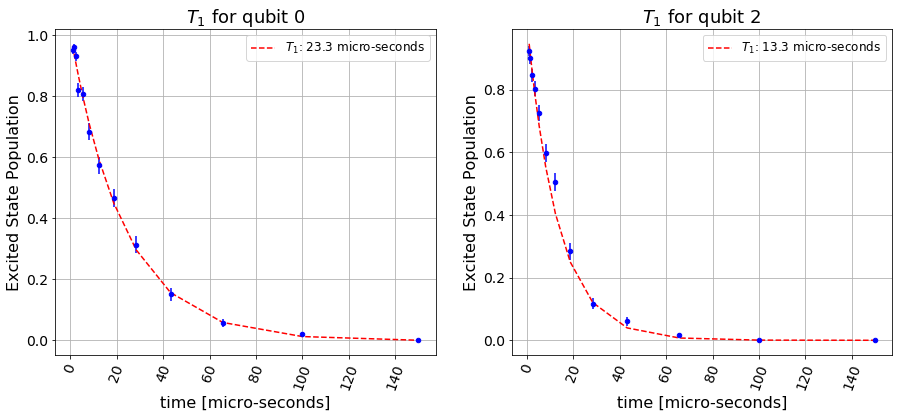

In [4]:
%matplotlib inline
# Fit the data to an exponential
# The correct answers are a=1, and c=0, and t1=25/15 for qubit 0/2
# The user does not know the correct answer exactly,
# so starts the fit from a different but close location

plt.figure(figsize=(15, 6))

initial_t1 = t1_0*1.2
initial_a = 1.0
initial_c = 0.0
fit = T1Fitter(backend_result, shots, xdata, qubits,
                   fit_p0=[initial_a, initial_t1, initial_c],
                   fit_bounds=([0, 0, -1], [2, initial_t1*2, 1]))

for i in range(2):
    ax = plt.subplot(1, 2, i+1)
    fit.plot_coherence(i, ax)
    
print(fit.time)
plt.show()

# Measuring $T_2^*$ time

**Theory**

Amplitude damping noise affects the off-diagonal elements of the density matrix in addition to the on-diagonal elements. However, there are other noise processes that only affect the off-diagonal elements, while keeping the on-diagonal elements the same. These kinds of noise processes cause _decoherence_.

As a simple example of decoherence, consider the pure superposition state
$$|\psi(\theta)\rangle = \frac{1}{\sqrt{2}}\left(|0\rangle + e^{i\theta}|1\rangle\right).$$
Expressed as a density matrix, this state is
$$\rho(\theta) = |\psi(\theta)\rangle \langle\psi(\theta)| = \frac{1}{2}\begin{pmatrix}1 & e^{-i\theta} \\ e^{i\theta} & 1\end{pmatrix}.$$

This state has _coherence_ between $|0\rangle$ and $|1\rangle$, which manifests itself in the non-zero off-diagonal terms. If the state had _decohered_, those off-diagonal terms would be zero:
$$\rho_{\mathrm{decohered}} =  \frac{1}{2}\begin{pmatrix}1 & 0 \\ 0 & 1\end{pmatrix}.$$
When the state has decohered, it can be written as a classical _mixture_:
$$\rho_{\mathrm{decohered}} = \frac{1}{2}\left(|0\rangle \langle 0| + |1\rangle \langle 1|\right).$$

One mechanism by which decoherence happens is _dephasing_. Under dephasing noise, the state of the qubit evolves as
$$\rho(t) = \begin{pmatrix}\rho_{00} & e^{-\Gamma_{2}t}\rho_{01} \\ e^{-\Gamma_{2}t}\rho_{01}^{\star} & \rho_{11}\end{pmatrix} \underset{t\rightarrow \infty}{\longrightarrow} \begin{pmatrix}\rho_{00} & 0\\ 0& \rho_{11}\end{pmatrix}.$$

The time evolution of $\rho$ under dephasing noise can be derived as the continuous-time limit of the following noise channel:
$$\mathcal{E}[\rho] = M_{0}\rho M_{0}^{\dagger} + M_{1} \rho M_{1}^{\dagger} + M_{2}\rho M_{2}^{\dagger},$$
where
$$M_{0} =\sqrt{1-p}I~,~M_{1} = \sqrt{p}\begin{pmatrix}1 &0 \\ 0 & 0 \end{pmatrix}~,~M_{2} = \sqrt{p}\begin{pmatrix}0 & 0 \\ 0 & 1\end{pmatrix}.$$


The rate of decay in the coherences can be measured by the following experiment:

* Prepare the qubit in the $|+\rangle$ state, which can be done by initializing the qubit to $|0\rangle$ and applying a Hadamard gate, $H$.
* Wait a delay time $t_{j}$.
* Measure the qubit in the $|\pm\rangle$ basis, which can be done by applying a Hadamard and then measuring in the computational basis.

If decoherence processes are present, then after a delay time $t_{j}$, the state of the qubit is

$$\rho(t_{j}) = \frac{1}{2}\begin{pmatrix}1 & e^{-\Gamma_{2}t_{j}} \\ e^{-\Gamma_{2}t_{j}} & 1\end{pmatrix}.$$

Measuring in the $|\pm\rangle$ basis, the probability of observing the outcome $|+\rangle$ is given by

$$P_{+}(t_{j}) = \mathrm{Tr}\left(|+\rangle \langle + | \rho(t_{j})\right) = \frac{1}{2}\left(1 + e^{-\Gamma_{2}t_{j}}\right).$$

Again, by estimating $P_{+}(t_{j})$ for a variety of $t_{j}$, we can then fit a decay curve to extract an estimate of $\Gamma_{2}$.

In the actual experiment, we change the phase of the pulse before the measurement in order to create oscillations in the observed dynamics of $P_{+}(t_{j})$. If we just did two Hadamard gates separated by a delay, we would observe a decay of characteristic time $T^*_2$, but with a strong dependence on any deviation of the calibrated qubit frequency from the actual one. By implementing the qubit pulses with different phases, we shift the frequency dependence into the oscillating feature of the dynamics, and can fit the decaying envelope for a more faithful measure of the coherence time.

In [5]:
# 50 points linearly spaced in two regions (fine and coarse)
# 30 from 10->150, 20 from 160->450
num_of_gates = np.append((np.linspace(10, 150, 30)).astype(int), (np.linspace(160,450,20)).astype(int))
gate_time = 0.1

# Select the qubits whose T2* are to be measured
qubits = [0, 2]

# Generate experiments
# omega is the oscillator's frequency
circs, xdata, osc_freq = t2star_circuits(num_of_gates, gate_time, qubits, nosc=5)

In [6]:
backend = qiskit.Aer.get_backend('qasm_simulator')

# Set the simulator with phase damping noise
t2_0 = 10
p = 1 - np.exp(-2*gate_time/t2_0)
error = phase_damping_error(p)
t2_1 = 5
p = 1 - np.exp(-2*gate_time/t2_1)
error2 = phase_damping_error(p)
noise_model = NoiseModel()
noise_model.add_quantum_error(error, 'id', [0])
noise_model.add_quantum_error(error2, 'id', [2])

# Run the simulator
shots = 300
backend_result = qiskit.execute(circs, backend,
                                shots=shots, noise_model=noise_model, backend_options={'max_parallel_experiments': 0}).result()

[10.360318180381197, 5.0420082843280545]


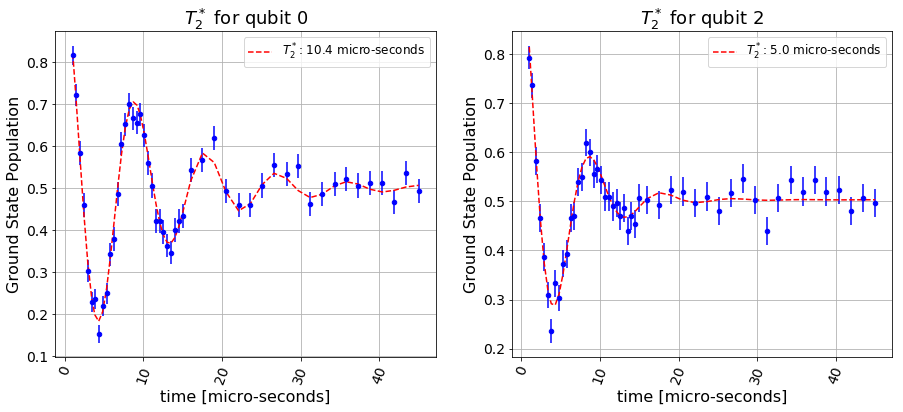

In [7]:
%matplotlib inline
# Fit the data to an oscillator
# The correct answers are a=0.5, f=omega, phi=0, c=0.5, and t2=10/5 for qubit 0/2
# The user does not know the correct answer exactly,
# so starts the fit from a different but close location

plt.figure(figsize=(15, 6))

initial_t2 = t2_0*1.1
initial_a = 1
initial_c = 0
initial_f = osc_freq 
initial_phi = -np.pi/20

fit = T2StarOscFitter(backend_result, shots, xdata, qubits,
                      fit_p0=[initial_a, initial_t2, initial_f, initial_phi, initial_c],
                      fit_bounds=([-0.5, 0, 0, -np.pi, -0.5],
                                  [1.5, 2*t2, 2*osc_freq, np.pi, 1.5]))

for i in range(2):
    ax = plt.subplot(1, 2, i+1)
    fit.plot_coherence(i, ax)
    
print(fit.time)
plt.show()

## Measuring T2 Time

Same as T2*, but with an echo pulse in the middle to remove low frequency noise.

In [8]:
# 50 points linearly spaced to 300
num_of_gates = (np.linspace(10, 300, 50)).astype(int)
gate_time = 0.1

# Select the qubits whose T2 are to be measured
qubits = [0, 2]

# Generate experiments
circs, xdata = t2_circuits(num_of_gates, gate_time, qubits)

In [9]:
backend = qiskit.Aer.get_backend('qasm_simulator')

# Set the simulator with phase damping noise
t2_0 = 10
p = 1 - np.exp(-2*gate_time/t2_0)
error = phase_damping_error(p)
t2_1 = 5
p = 1 - np.exp(-2*gate_time/t2_1)
error2 = phase_damping_error(p)
noise_model = NoiseModel()
noise_model.add_quantum_error(error, 'id', [0])
noise_model.add_quantum_error(error2, 'id', [2])

# Run the simulator
shots = 300
backend_result = qiskit.execute(circs, backend,
                                shots=shots, noise_model=noise_model, backend_options={'max_parallel_experiments': 0}).result()

[9.072370769245818, 5.792676462041808]


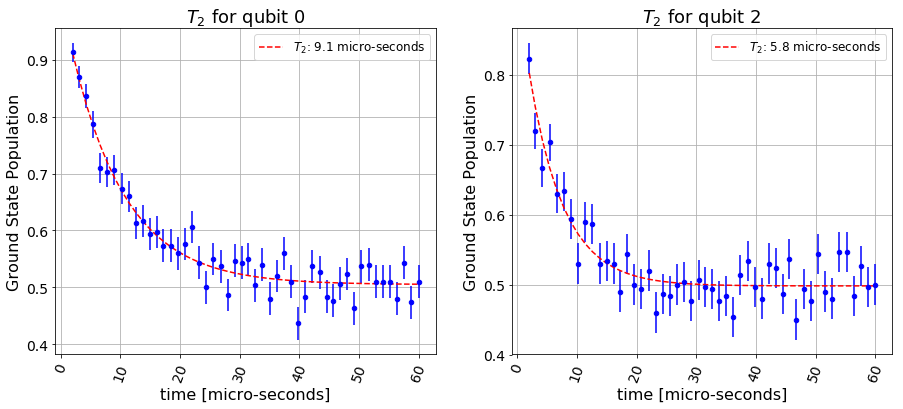

In [10]:
%matplotlib inline
# Fit the data to an exponent
# The correct answers are a=1, c=0, and t2=10/5 for qubit 0/2
# The user does not know the correct answer exactly,
# so starts the fit from a different but close location

plt.figure(figsize=(15, 6))

initial_t2 = t2_0*1.1
initial_a = 1
initial_c = 0

fit = T2Fitter(backend_result, shots, xdata, qubits,
                      fit_p0=[initial_a, initial_t2, initial_c],
                      fit_bounds=([-0.5, 0, -0.5],
                                  [1.5, 2*t2, 1.5]))

for i in range(2):
    ax = plt.subplot(1, 2, i+1)
    fit.plot_coherence(i, ax)
    
print(fit.time)
plt.show()